In [1]:
import os
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,roc_curve, auc
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 1234

In [2]:

# Must be included at the beginning of each new notebook. Remember to change the app name.
from pyspark.sql import SparkSession
import pyspark
import findspark
import pyspark.pandas as ps
import pyspark.sql.functions as f
from pyspark.sql.window import Window
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
spark = SparkSession.builder.appName('basics').getOrCreate()
ps.set_option('compute.ops_on_diff_frames', True)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/12 04:40:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# #Data Understanding


In [3]:
df = spark.read.csv('Europe Hotel Booking Satisfaction Score train.csv',header=True, inferSchema=True)
print("The shape of data is: ({0},{1})".format(df.count(),len(df.columns)))
df.limit(5).toPandas()

The shape of data is: (103904,17)


,id,Gender,Age,purpose_of_travel,Type of Travel,Type Of Booking,Hotel wifi service,Departure/Arrival convenience,Ease of Online booking,Hotel location,Food and drink,Stay comfort,Common Room entertainment,Checkin/Checkout service,Other service,Cleanliness,satisfaction
0,70172,Male,13,aviation,Personal Travel,Not defined,3,4,3,1,5,5,5,4,5,5,neutral or dissatisfied
1,5047,Male,25,tourism,Group Travel,Group bookings,3,2,3,3,1,1,1,1,4,1,neutral or dissatisfied
2,110028,Female,26,tourism,Group Travel,Group bookings,2,2,2,2,5,5,5,4,4,5,satisfied
3,24026,Female,25,tourism,Group Travel,Group bookings,2,5,5,5,2,2,2,1,4,2,neutral or dissatisfied
4,119299,Male,61,aviation,Group Travel,Group bookings,3,3,3,3,4,5,3,3,3,3,satisfied


In [4]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- purpose_of_travel: string (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Type Of Booking: string (nullable = true)
 |-- Hotel wifi service: integer (nullable = true)
 |-- Departure/Arrival  convenience: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Hotel location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Stay comfort: integer (nullable = true)
 |-- Common Room entertainment: integer (nullable = true)
 |-- Checkin/Checkout service: integer (nullable = true)
 |-- Other service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- satisfaction: string (nullable = true)



In [5]:
s = df.groupBy('satisfaction').count().orderBy('satisfaction')
df_satisfaction = s.withColumn("Percentage(%)",f.round(f.col('count')/f.sum('count').over(Window.partitionBy())*100,2))
y, x= df_satisfaction.select('satisfaction').collect(), df_satisfaction.select('count').collect()
df_satisfaction.show()

23/10/12 04:40:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/12 04:40:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/12 04:40:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/12 04:40:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/12 04:40:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------------+-----+-------------+
|        satisfaction|count|Percentage(%)|
+--------------------+-----+-------------+
|neutral or dissat...|58879|        56.67|
|           satisfied|45025|        43.33|
+--------------------+-----+-------------+



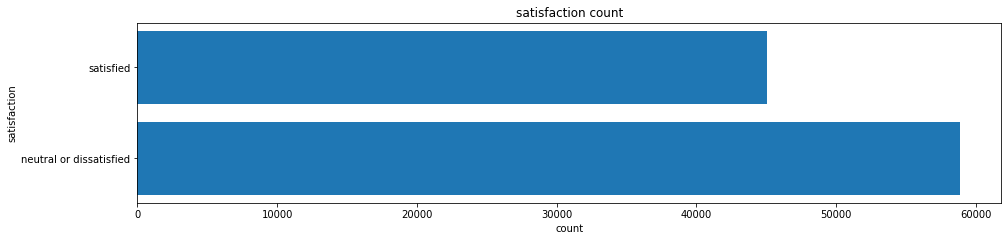

In [6]:
fig = plt.figure(figsize = (12,2.5))
ax = fig.add_axes([0,0,1,1])
ax.barh(np.array(y).flatten(),np.array(x).flatten())
ax.set_yticks(np.array(y).flatten())
ax.set_ylabel('satisfaction')
ax.set_xlabel('count')
ax.set_title('satisfaction count')
plt.show()

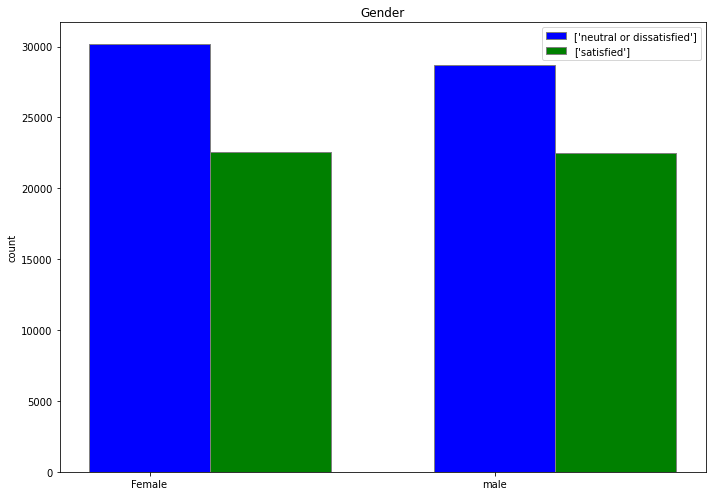

In [7]:
gender = np.array(df.groupBy('Gender','satisfaction').count().
                groupBy('satisfaction').pivot('Gender').sum("count").
                orderBy('satisfaction').collect())
gender
labels = ['Female','male']
neutral_dis = gender[0,1:].astype('int')
satis = gender[1,1:].astype('int')
width = 0.35  

x = np.arange(len(labels)) 

br1 = np.arange(len(neutral_dis))
br2 = [x + width for x in br1]

fig, ax = plt.subplots(figsize=(10, 7))
plt.bar(br1, neutral_dis, color ='b', width = width,
        edgecolor ='grey', label =gender[0,:1])
plt.bar(br2, satis, color ='g', width = width,
        edgecolor ='grey', label =gender[1,:1])

ax.set_ylabel('count')
ax.set_title('Gender')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

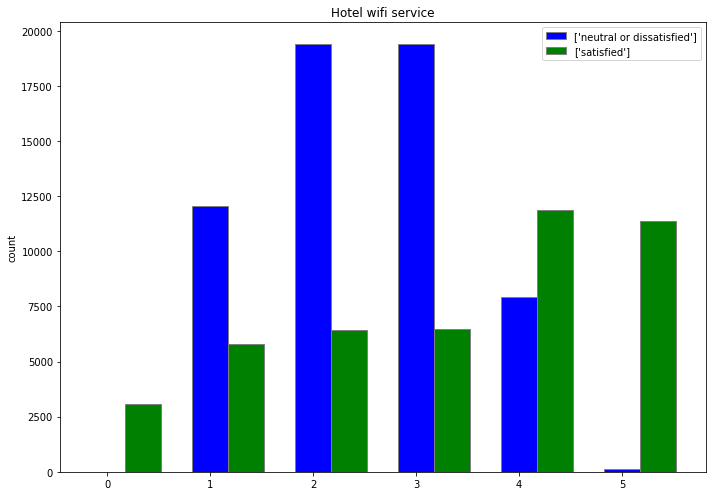

In [8]:
wifi = np.array(df.groupBy('Hotel wifi service','satisfaction').
                count().groupBy('satisfaction').pivot('Hotel wifi service').
                sum("count").orderBy('satisfaction').collect())
wifi
labels = ['0','1','2','3','4','5']
neutral_dis = wifi[0,1:].astype('int')
satis = wifi[1,1:].astype('int')
width = 0.35  

x = np.arange(len(labels)) 
br1 = np.arange(len(neutral_dis))
br2 = [x + width for x in br1]

fig, ax = plt.subplots(figsize=(10, 7))
plt.bar(br1, neutral_dis, color ='b', width = width,
        edgecolor ='grey', label =wifi[0,:1])
plt.bar(br2, satis, color ='g', width = width,
        edgecolor ='grey', label =wifi[1,:1])

ax.set_ylabel('count')
ax.set_title('Hotel wifi service')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

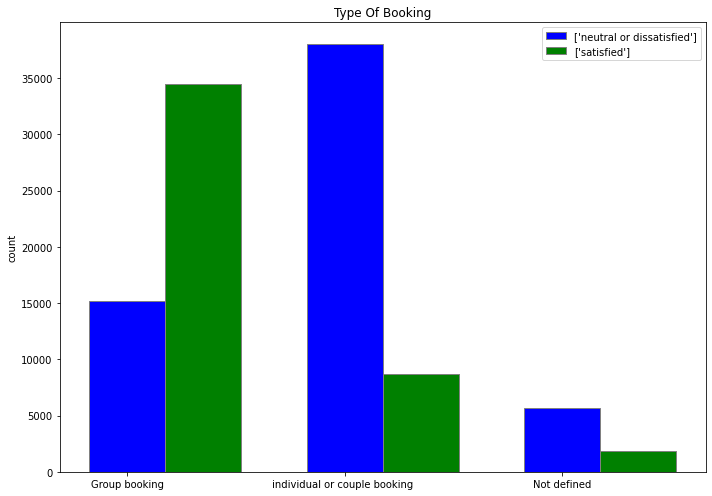

In [9]:
booking = np.array(df.groupBy('Type Of Booking','satisfaction').count().
                groupBy('satisfaction').pivot('Type Of Booking').sum("count").
                orderBy('satisfaction').collect())
booking
labels = ['Group booking','individual or couple booking ','Not defined']
neutral_dis = booking[0,1:].astype('int')
satis = booking[1,1:].astype('int')
width = 0.35  

x = np.arange(len(labels)) 

br1 = np.arange(len(neutral_dis))
br2 = [x + width for x in br1]

fig, ax = plt.subplots(figsize=(10, 7))
plt.bar(br1, neutral_dis, color ='b', width = width,
        edgecolor ='grey', label =booking[0,:1])
plt.bar(br2, satis, color ='g', width = width,
        edgecolor ='grey', label =booking[1,:1])

ax.set_ylabel('count')
ax.set_title('Type Of Booking')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

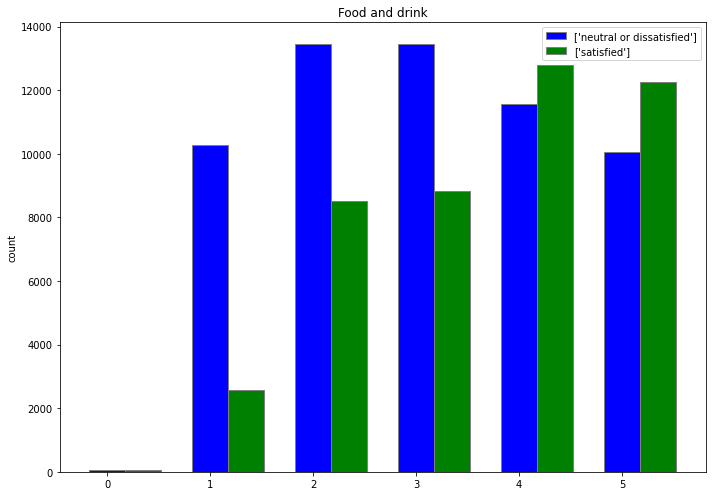

In [10]:
foodanddrink = np.array(df.groupBy('Food and drink','satisfaction').count().
                groupBy('satisfaction').pivot('Food and drink').sum("count").
                orderBy('satisfaction').collect())
foodanddrink
labels = ['0','1','2','3','4','5']
neutral_dis = foodanddrink[0,1:].astype('int')
satis = foodanddrink[1,1:].astype('int')
width = 0.35  

x = np.arange(len(labels)) 
br1 = np.arange(len(neutral_dis))
br2 = [x + width for x in br1]

fig, ax = plt.subplots(figsize=(10, 7))
plt.bar(br1, neutral_dis, color ='b', width = width,
        edgecolor ='grey', label =foodanddrink[0,:1])
plt.bar(br2, satis, color ='g', width = width,
        edgecolor ='grey', label =foodanddrink[1,:1])

ax.set_ylabel('count')
ax.set_title('Food and drink')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

In [11]:
stay_comfort = np.array(df.groupBy('Stay comfort','satisfaction').count().
                groupBy('satisfaction').pivot('Stay comfort').sum("count").
                orderBy('satisfaction').collect())
stay_comfort

array([['neutral or dissatisfied', 1, 9380, 11558, 14741, 13940, 9259],
       ['satisfied', None, 2695, 3339, 3955, 17825, 17211]], dtype=object)

In [12]:
stay_comfort[1,1:]

array([None, 2695, 3339, 3955, 17825, 17211], dtype=object)

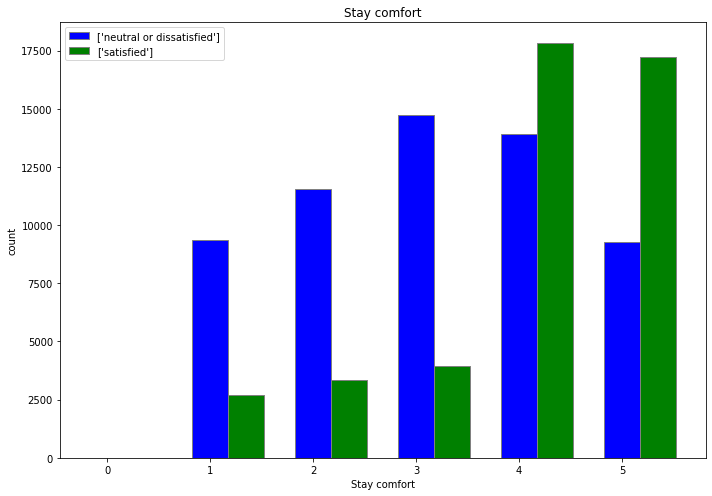

In [13]:
labels = ['0','1','2','3','4','5']
neutral_dis = stay_comfort[0,1:].astype('int')
stay_comfort[1,1]=0
satis = stay_comfort[1,1:].astype('int')
width = 0.35  

x = np.arange(len(labels))  

br1 = np.arange(len(neutral_dis))
br2 = [x + width for x in br1]

fig, ax = plt.subplots(figsize=(10, 7))
plt.bar(br1, neutral_dis, color ='b', width = width,
        edgecolor ='grey', label =stay_comfort[0,:1])
plt.bar(br2, satis, color ='g', width = width,
        edgecolor ='grey', label =stay_comfort[1,:1])

ax.set_ylabel('count')
ax.set_xlabel('Stay comfort')
ax.set_title('Stay comfort')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

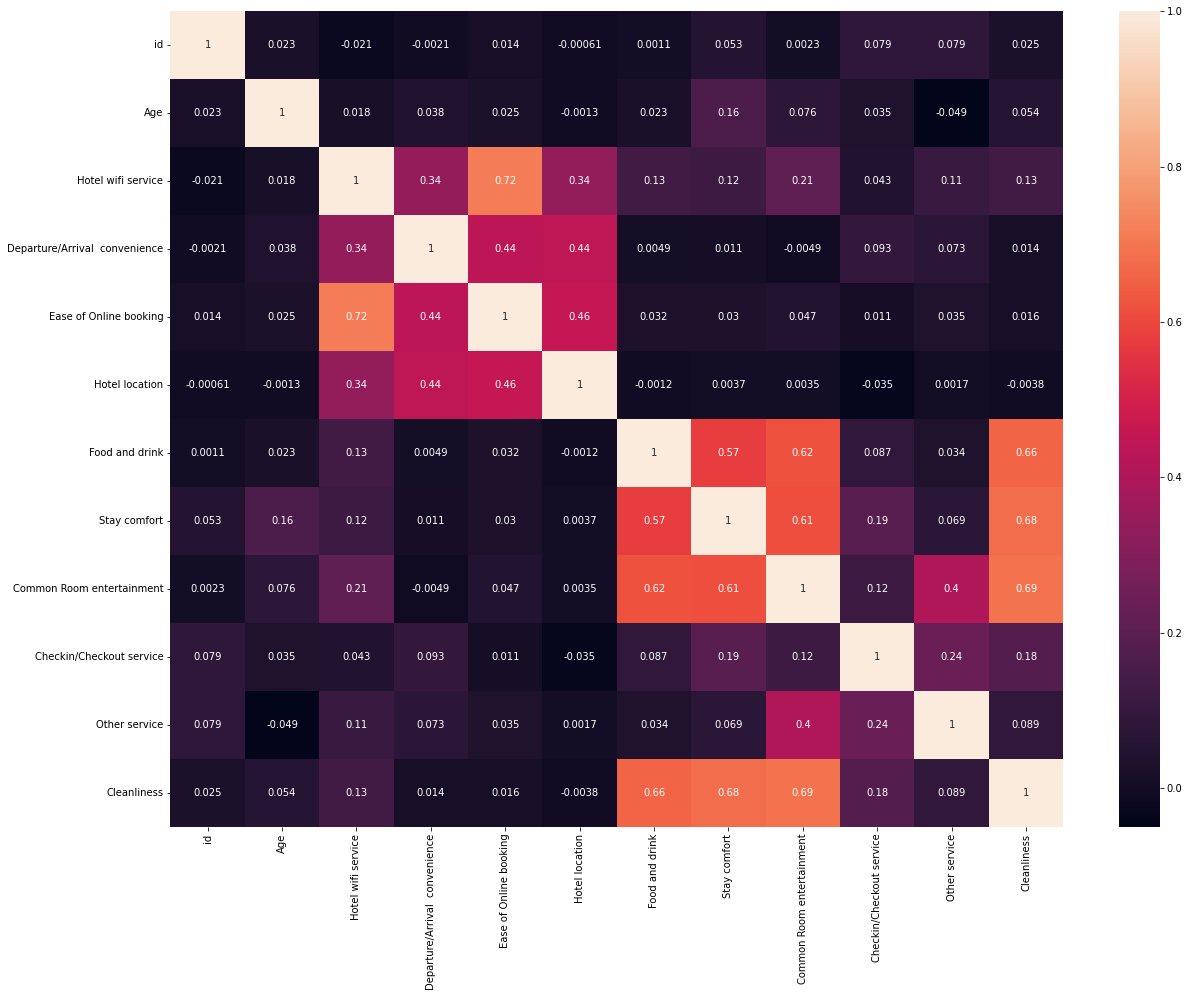

In [14]:
correlation_map = df.toPandas().corr()
top_feature = correlation_map.index
plt.figure(figsize=(20,15))
sns.heatmap(df.toPandas()[top_feature].corr(),annot=True)
plt.show

In [15]:
from pyspark.sql.functions import isnan,when,count,col
df_count = df.count()
df.select([count(when(isnan(c)| col(c).isNull(),c)).alias(c) for c in df.columns]).show()

+---+------+---+-----------------+--------------+---------------+------------------+------------------------------+----------------------+--------------+--------------+------------+-------------------------+------------------------+-------------+-----------+------------+
| id|Gender|Age|purpose_of_travel|Type of Travel|Type Of Booking|Hotel wifi service|Departure/Arrival  convenience|Ease of Online booking|Hotel location|Food and drink|Stay comfort|Common Room entertainment|Checkin/Checkout service|Other service|Cleanliness|satisfaction|
+---+------+---+-----------------+--------------+---------------+------------------+------------------------------+----------------------+--------------+--------------+------------+-------------------------+------------------------+-------------+-----------+------------+
|  0|     0|  0|                0|             0|              0|                 0|                             0|                     0|             0|             0|           0|   

In [16]:
print("The shape of data is: ({0},{1})".format(df.count(),len(df.columns)))

The shape of data is: (103904,17)


In [17]:
completeness = (103904-25)/103904
print(completeness)

0.9997593932861103


In [18]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- purpose_of_travel: string (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Type Of Booking: string (nullable = true)
 |-- Hotel wifi service: integer (nullable = true)
 |-- Departure/Arrival  convenience: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Hotel location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Stay comfort: integer (nullable = true)
 |-- Common Room entertainment: integer (nullable = true)
 |-- Checkin/Checkout service: integer (nullable = true)
 |-- Other service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- satisfaction: string (nullable = true)



# #Data Preparation

In [19]:
df.describe().show()

+-------+-----------------+------+------------------+-----------------+---------------+---------------+------------------+------------------------------+----------------------+------------------+------------------+------------------+-------------------------+------------------------+------------------+------------------+--------------------+
|summary|               id|Gender|               Age|purpose_of_travel| Type of Travel|Type Of Booking|Hotel wifi service|Departure/Arrival  convenience|Ease of Online booking|    Hotel location|    Food and drink|      Stay comfort|Common Room entertainment|Checkin/Checkout service|     Other service|       Cleanliness|        satisfaction|
+-------+-----------------+------+------------------+-----------------+---------------+---------------+------------------+------------------------------+----------------------+------------------+------------------+------------------+-------------------------+------------------------+------------------+---------

In [20]:
df_clean = df.drop('id')

In [21]:
for col in df_clean.dtypes:
    print(col[0])

Gender
Age
purpose_of_travel
Type of Travel
Type Of Booking
Hotel wifi service
Departure/Arrival  convenience
Ease of Online booking
Hotel location
Food and drink
Stay comfort
Common Room entertainment
Checkin/Checkout service
Other service
Cleanliness
satisfaction


In [22]:
from pyspark.sql.functions import isnan,when,count,col
df_clean_count = df_clean.count()
df_clean.select([count(when(isnan(c)| col(c).isNull(),c)).alias(c) for c in df_clean.columns]).show()

+------+---+-----------------+--------------+---------------+------------------+------------------------------+----------------------+--------------+--------------+------------+-------------------------+------------------------+-------------+-----------+------------+
|Gender|Age|purpose_of_travel|Type of Travel|Type Of Booking|Hotel wifi service|Departure/Arrival  convenience|Ease of Online booking|Hotel location|Food and drink|Stay comfort|Common Room entertainment|Checkin/Checkout service|Other service|Cleanliness|satisfaction|
+------+---+-----------------+--------------+---------------+------------------+------------------------------+----------------------+--------------+--------------+------------+-------------------------+------------------------+-------------+-----------+------------+
|     0|  0|                0|             0|              0|                 0|                             0|                     0|             0|             0|           0|                   

In [23]:
print("The shape of data is: ({0},{1})".format(df_clean.count(),len(df_clean.columns)))

The shape of data is: (103904,16)


In [24]:
#df_clean.show()

In [25]:
from pyspark.sql.functions import isnan, when, count, col, mean
# Calculate the mean value of the "Cleanliness" column
mean_cleanliness = df_clean.select(mean("Cleanliness")).collect()[0][0]
# Fill missing values in the "Cleanliness" column with the mean value
df_clean2 = df_clean.withColumn("Cleanliness", when(isnan(col("Cleanliness"))
                                                   | col("Cleanliness").isNull(), 
                                                    mean_cleanliness).otherwise(col("Cleanliness")))

df_clean2_count = df_clean2.count()
df_clean2.select([count(when(isnan(c)| col(c).isNull(),c)).alias(c) for c in df_clean2.columns]).show()

+------+---+-----------------+--------------+---------------+------------------+------------------------------+----------------------+--------------+--------------+------------+-------------------------+------------------------+-------------+-----------+------------+
|Gender|Age|purpose_of_travel|Type of Travel|Type Of Booking|Hotel wifi service|Departure/Arrival  convenience|Ease of Online booking|Hotel location|Food and drink|Stay comfort|Common Room entertainment|Checkin/Checkout service|Other service|Cleanliness|satisfaction|
+------+---+-----------------+--------------+---------------+------------------+------------------------------+----------------------+--------------+--------------+------------+-------------------------+------------------------+-------------+-----------+------------+
|     0|  0|                0|             0|              0|                 0|                             0|                     0|             0|             0|           0|                   

In [26]:
df_clean2.printSchema()
df_clean2.select("Cleanliness").show()

root
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- purpose_of_travel: string (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Type Of Booking: string (nullable = true)
 |-- Hotel wifi service: integer (nullable = true)
 |-- Departure/Arrival  convenience: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Hotel location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Stay comfort: integer (nullable = true)
 |-- Common Room entertainment: integer (nullable = true)
 |-- Checkin/Checkout service: integer (nullable = true)
 |-- Other service: integer (nullable = true)
 |-- Cleanliness: double (nullable = true)
 |-- satisfaction: string (nullable = true)

+------------------+
|       Cleanliness|
+------------------+
|               5.0|
|               1.0|
|               5.0|
|               2.0|
|               3.0|
|               1.0|
|               2.0|
|           

In [27]:
# Convert the "Cleanliness" column to an integer
df_clean2 = df_clean2.withColumn("Cleanliness", df_clean2["Cleanliness"].cast("int"))

In [28]:
# Show the "Cleanliness" column in the DataFrame
df_clean2.printSchema()
df_clean2.select("Cleanliness").show()

root
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- purpose_of_travel: string (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Type Of Booking: string (nullable = true)
 |-- Hotel wifi service: integer (nullable = true)
 |-- Departure/Arrival  convenience: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Hotel location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Stay comfort: integer (nullable = true)
 |-- Common Room entertainment: integer (nullable = true)
 |-- Checkin/Checkout service: integer (nullable = true)
 |-- Other service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- satisfaction: string (nullable = true)

+-----------+
|Cleanliness|
+-----------+
|          5|
|          1|
|          5|
|          2|
|          3|
|          1|
|          2|
|          4|
|          3|
|          2|
|          2|
|          1|
|          

In [29]:
from pyspark.sql.functions import when, col
import pyspark.pandas as ps

# Create a new column "satisfaction_encoded" based on the mapping
df_clean2 = df_clean2.withColumn(
    "customer_satisfaction",
    when(col("satisfaction") == "neutral or dissatisfied", 0)
    .when(col("satisfaction") == "satisfied", 1)
    .otherwise(None)
)

# Show the updated DataFrame
df_clean2.select("satisfaction", "customer_satisfaction").show()
df_clean2.printSchema()

+--------------------+---------------------+
|        satisfaction|customer_satisfaction|
+--------------------+---------------------+
|neutral or dissat...|                    0|
|neutral or dissat...|                    0|
|           satisfied|                    1|
|neutral or dissat...|                    0|
|           satisfied|                    1|
|neutral or dissat...|                    0|
|neutral or dissat...|                    0|
|           satisfied|                    1|
|neutral or dissat...|                    0|
|neutral or dissat...|                    0|
|neutral or dissat...|                    0|
|neutral or dissat...|                    0|
|neutral or dissat...|                    0|
|           satisfied|                    1|
|neutral or dissat...|                    0|
|neutral or dissat...|                    0|
|           satisfied|                    1|
|           satisfied|                    1|
|           satisfied|                    1|
|neutral o

## Format the data as required

In [30]:
print(np.array(df_clean2.select('Gender').distinct().collect()).flatten())
print(np.array(df_clean2.select('Type Of Booking').distinct().collect()).flatten())
print(np.array(df_clean2.select('Type of Travel').distinct().collect()).flatten())
print(np.array(df_clean2.select('purpose_of_travel').distinct().collect()).flatten())

['Female' 'Male']
['Group bookings' 'Individual/Couple' 'Not defined']
['Group Travel' 'Personal Travel']
['tourism' 'academic' 'personal' 'aviation' 'business']


In [31]:
df_clean2 = df_clean2.withColumnRenamed("Type Of Booking","Type_Of_Booking") \
    .withColumnRenamed("Type of Travel","Type_of_Travel")

In [32]:
df_encoded = df_clean2

In [33]:
df_encoded = df_encoded.withColumn('Type_of_Travel', 
                                       f.when(f.col('Type_of_Travel') == 'Personal Travel', '1')
                                       .otherwise('0'))

In [34]:
df_encoded = df_encoded.withColumn('Gender', 
                                       f.when(f.col('Gender') == 'Female', '1')
                                       .otherwise('0'))

In [35]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType


def Class_reclassify(x):
    if x == 'Not defined':
        return '0'
    if x == 'Group bookings':
        return '1'
    if x == 'Individual/Couple':
        return '2'
    
class_re = udf(Class_reclassify, StringType())
df_encoded = df_encoded.withColumn('Type_Of_Booking', class_re('Type_Of_Booking'))

In [36]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType


def Class_reclassify2(x):
    if x == 'aviation':
        return '0'
    if x == 'tourism':
        return '1'
    if x == 'business':
        return '2'
    if x == 'academic':
        return '3'
    if x == 'personal':
        return '4'
    
    
    
class_re = udf(Class_reclassify2, StringType())
df_encoded = df_encoded.withColumn('purpose_of_travel', class_re('purpose_of_travel'))

In [37]:
df_clean2.select(col('Gender'),col('Type_of_Travel'),col('Type_Of_Booking'),
                     col('purpose_of_travel')).show(10)

+------+---------------+-----------------+-----------------+
|Gender| Type_of_Travel|  Type_Of_Booking|purpose_of_travel|
+------+---------------+-----------------+-----------------+
|  Male|Personal Travel|      Not defined|         aviation|
|  Male|   Group Travel|   Group bookings|          tourism|
|Female|   Group Travel|   Group bookings|          tourism|
|Female|   Group Travel|   Group bookings|          tourism|
|  Male|   Group Travel|   Group bookings|         aviation|
|Female|Personal Travel|Individual/Couple|         business|
|  Male|Personal Travel|Individual/Couple|         academic|
|Female|   Group Travel|   Group bookings|         aviation|
|Female|   Group Travel|   Group bookings|          tourism|
|  Male|   Group Travel|Individual/Couple|         academic|
+------+---------------+-----------------+-----------------+
only showing top 10 rows



In [38]:
df_encoded.select(col('Gender'),col('Type_of_Travel'),col('Type_Of_Booking'),
                     col('purpose_of_travel')).show(10)

+------+--------------+---------------+-----------------+
|Gender|Type_of_Travel|Type_Of_Booking|purpose_of_travel|
+------+--------------+---------------+-----------------+
|     0|             1|              0|                0|
|     0|             0|              1|                1|
|     1|             0|              1|                1|
|     1|             0|              1|                1|
|     0|             0|              1|                0|
|     1|             1|              2|                2|
|     0|             1|              2|                3|
|     1|             0|              1|                0|
|     1|             0|              1|                1|
|     0|             0|              2|                3|
+------+--------------+---------------+-----------------+
only showing top 10 rows



In [39]:
df_encoded.printSchema()

root
 |-- Gender: string (nullable = false)
 |-- Age: integer (nullable = true)
 |-- purpose_of_travel: string (nullable = true)
 |-- Type_of_Travel: string (nullable = false)
 |-- Type_Of_Booking: string (nullable = true)
 |-- Hotel wifi service: integer (nullable = true)
 |-- Departure/Arrival  convenience: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Hotel location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Stay comfort: integer (nullable = true)
 |-- Common Room entertainment: integer (nullable = true)
 |-- Checkin/Checkout service: integer (nullable = true)
 |-- Other service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- satisfaction: string (nullable = true)
 |-- customer_satisfaction: integer (nullable = true)



## Step 4. Data transformation 

In [40]:
df_new = df_encoded.drop('satisfaction')

In [41]:
df_new.printSchema()

root
 |-- Gender: string (nullable = false)
 |-- Age: integer (nullable = true)
 |-- purpose_of_travel: string (nullable = true)
 |-- Type_of_Travel: string (nullable = false)
 |-- Type_Of_Booking: string (nullable = true)
 |-- Hotel wifi service: integer (nullable = true)
 |-- Departure/Arrival  convenience: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Hotel location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Stay comfort: integer (nullable = true)
 |-- Common Room entertainment: integer (nullable = true)
 |-- Checkin/Checkout service: integer (nullable = true)
 |-- Other service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- customer_satisfaction: integer (nullable = true)



In [42]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)

In [43]:
column = ['Gender',
             'Age',
             'purpose_of_travel',
             'Type_of_Travel',
             'Type_Of_Booking',
             'Hotel wifi service',
             'Departure/Arrival  convenience',
             'Ease of Online booking',
             'Hotel location',
             'Food and drink',
             'Stay comfort',
             'Common Room entertainment',
             'Checkin/Checkout service',
             'Other service',
             'Cleanliness',
             'customer_satisfaction']
for i in column:
    indexer = StringIndexer(inputCol =i, outputCol= i+"Index" )
    model = indexer.fit(df_new)
    indexed = model.transform(df_new)
    df_new = indexed

In [44]:
df_new2 = df_new.drop(*column)

In [45]:
df_new2.show(5)

+-----------+--------+----------------------+-------------------+--------------------+-----------------------+-----------------------------------+---------------------------+-------------------+-------------------+-----------------+------------------------------+-----------------------------+------------------+----------------+--------------------------+
|GenderIndex|AgeIndex|purpose_of_travelIndex|Type_of_TravelIndex|Type_Of_BookingIndex|Hotel wifi serviceIndex|Departure/Arrival  convenienceIndex|Ease of Online bookingIndex|Hotel locationIndex|Food and drinkIndex|Stay comfortIndex|Common Room entertainmentIndex|Checkin/Checkout serviceIndex|Other serviceIndex|CleanlinessIndex|customer_satisfactionIndex|
+-----------+--------+----------------------+-------------------+--------------------+-----------------------+-----------------------------------+---------------------------+-------------------+-------------------+-----------------+------------------------------+-----------------------

In [46]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorSlicer, MinMaxScaler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, \
    DecisionTreeClassifier, MultilayerPerceptronClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [47]:
# Assemble features into a vector column
vecAssembler = VectorAssembler(inputCols=df_new2.drop('customer_satisfactionIndex').columns, outputCol="features")
data = vecAssembler.transform(df_new2)
(trainingData, testData) = data.randomSplit([0.8, 0.2])

evaluator = MulticlassClassificationEvaluator(
    labelCol="customer_satisfactionIndex", predictionCol="prediction", metricName="accuracy")
n_att = 15

rf = RandomForestClassifier(labelCol="customer_satisfactionIndex", featuresCol="features",maxBins=100,
                            numTrees=100, cacheNodeIds = True, subsamplingRate = 0.8)
pipe = Pipeline(stages = [rf])
mod = pipe.fit(trainingData)
feature_imp = mod.stages[-1].featureImportances
list_extract = []
for i in trainingData.schema['features'].metadata["ml_attr"]["attrs"]:
    list_extract = list_extract + trainingData.schema['features'].metadata["ml_attr"]["attrs"][i]
for i in range(len(list_extract)):
    list_extract[i]['score'] = feature_imp[i]
list_extract = sorted(list_extract, key = lambda x: x['score'], reverse = True)
list_features = [x['name'] for x in list_extract]


predictions = mod.transform(testData)
acc = evaluator.evaluate(predictions)

for i in range(n_att-1,n_att-5,-1):
    varidx = [x['idx'] for x in list_extract][:i]
    slicer = VectorSlicer(inputCol="features", outputCol="features2", indices = varidx)
    trainingData = slicer.transform(trainingData).withColumn('features', f.col('features2')).drop('features2')
    mod = pipe.fit(trainingData)
    feature_imp = mod.stages[-1].featureImportances
    
    list_extract = [{'idx':j, 'name':list_extract[varidx[j]]['name'], 'score':feature_imp[j]} 
                    for j in range(len(varidx))]
    list_extract = sorted(list_extract, key = lambda x: x['score'], reverse = True)
    
    testData = slicer.transform(testData).withColumn('features', f.col('features2')).drop('features2')
    predictions = mod.transform(testData)
    accuracy = evaluator.evaluate(predictions)
    if (accuracy > acc):
        acc, n_att = accuracy, i
        list_features = [x['name'] for x in list_extract]

print("Optimum number of features: {}".format(n_att))
print("Score with {} features: {:.6f}".format(n_att, acc))

print("Features selected:\n{}".format(list_features))

Optimum number of features: 13
Score with 13 features: 0.917630
Features selected:
['Stay comfortIndex', 'Ease of Online bookingIndex', 'Common Room entertainmentIndex', 'Departure/Arrival  convenienceIndex', 'Hotel locationIndex', 'Other serviceIndex', 'purpose_of_travelIndex', 'GenderIndex', 'Type_Of_BookingIndex', 'Food and drinkIndex', 'AgeIndex', 'CleanlinessIndex', 'Checkin/Checkout serviceIndex']


In [48]:
df_new3 = df_new2.drop("Type_of_TravelIndex")

<function matplotlib.pyplot.show(close=None, block=None)>

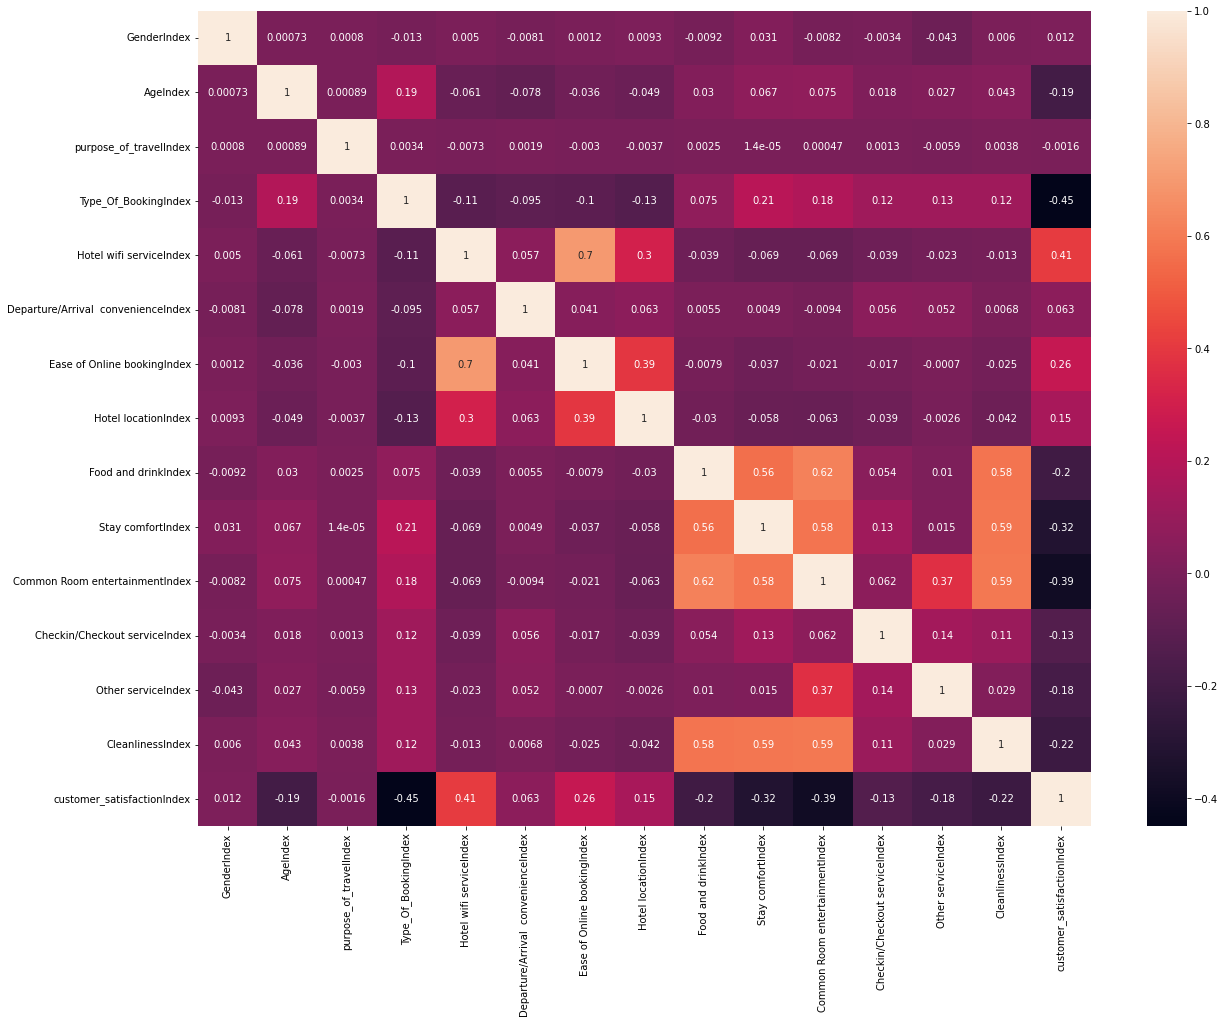

In [49]:
correlation_map = df_new3.toPandas().corr()
top_feature = correlation_map.index
plt.figure(figsize=(20,15))
sns.heatmap(df_new3.toPandas()[top_feature].corr(),annot=True)
plt.show

In [50]:
df_new3

DataFrame[GenderIndex: double, AgeIndex: double, purpose_of_travelIndex: double, Type_Of_BookingIndex: double, Hotel wifi serviceIndex: double, Departure/Arrival  convenienceIndex: double, Ease of Online bookingIndex: double, Hotel locationIndex: double, Food and drinkIndex: double, Stay comfortIndex: double, Common Room entertainmentIndex: double, Checkin/Checkout serviceIndex: double, Other serviceIndex: double, CleanlinessIndex: double, customer_satisfactionIndex: double]

In [51]:
# Total number of columns
num_columns = len(df_new3.columns)
# Total number of rows
num_rows = df_new3.count()
# Print the total number of columns and rows
print(f"Total Columns: {num_columns}")
print(f"Total Rows: {num_rows}")


Total Columns: 15
Total Rows: 103904


In [52]:
from pyspark.sql.functions import col, explode, array, lit
df_0 = df_new3.filter(col("customer_satisfactionIndex") == 0)
df_1 = df_new3.filter(col("customer_satisfactionIndex") == 1)
print(df_0.count(),df_1.count())

58879 45025


In [53]:
df_a = df_new3.filter(col("customer_satisfactionIndex") == 0)
df_b = df_new3.filter(col("customer_satisfactionIndex") == 1)

a_count = df_a.count()
b_count = df_b.count() 
ratio = a_count / b_count

df_re_sample = df_b.sample(withReplacement=True, fraction=ratio, seed=1)
df_resampled = df_a.unionAll(df_re_sample)

In [54]:
df_0 = df_resampled.filter(col("customer_satisfactionIndex") == 0)
df_1 = df_resampled.filter(col("customer_satisfactionIndex") == 1)
print(df_0.count(),df_1.count())


58879 59035


In [55]:
# Total number of columns
num_columns = len(df_resampled.columns)
# Total number of rows
num_rows = df_resampled.count()
# Print the total number of columns and rows
print(f"Total Columns: {num_columns}")
print(f"Total Rows: {num_rows}")

Total Columns: 15
Total Rows: 117914


In [56]:
df_resampled.head()

Row(GenderIndex=1.0, AgeIndex=61.0, purpose_of_travelIndex=3.0, Type_Of_BookingIndex=2.0, Hotel wifi serviceIndex=0.0, Departure/Arrival  convenienceIndex=0.0, Ease of Online bookingIndex=0.0, Hotel locationIndex=3.0, Food and drinkIndex=1.0, Stay comfortIndex=1.0, Common Room entertainmentIndex=1.0, Checkin/Checkout serviceIndex=0.0, Other serviceIndex=1.0, CleanlinessIndex=2.0, customer_satisfactionIndex=0.0)

In [57]:
print("The shape of data is: ({0},{1})".format(df_resampled.count(),len(df_resampled.columns)))

The shape of data is: (117914,15)


In [58]:
df_resampled.printSchema()

root
 |-- GenderIndex: double (nullable = false)
 |-- AgeIndex: double (nullable = false)
 |-- purpose_of_travelIndex: double (nullable = false)
 |-- Type_Of_BookingIndex: double (nullable = false)
 |-- Hotel wifi serviceIndex: double (nullable = false)
 |-- Departure/Arrival  convenienceIndex: double (nullable = false)
 |-- Ease of Online bookingIndex: double (nullable = false)
 |-- Hotel locationIndex: double (nullable = false)
 |-- Food and drinkIndex: double (nullable = false)
 |-- Stay comfortIndex: double (nullable = false)
 |-- Common Room entertainmentIndex: double (nullable = false)
 |-- Checkin/Checkout serviceIndex: double (nullable = false)
 |-- Other serviceIndex: double (nullable = false)
 |-- CleanlinessIndex: double (nullable = false)
 |-- customer_satisfactionIndex: double (nullable = false)



In [59]:
df_resampled_count = df_resampled.count()
df_resampled.select([count(when(isnan(c)| col(c).isNull(),c)).alias(c) for c in df_resampled.columns]).show()

+-----------+--------+----------------------+--------------------+-----------------------+-----------------------------------+---------------------------+-------------------+-------------------+-----------------+------------------------------+-----------------------------+------------------+----------------+--------------------------+
|GenderIndex|AgeIndex|purpose_of_travelIndex|Type_Of_BookingIndex|Hotel wifi serviceIndex|Departure/Arrival  convenienceIndex|Ease of Online bookingIndex|Hotel locationIndex|Food and drinkIndex|Stay comfortIndex|Common Room entertainmentIndex|Checkin/Checkout serviceIndex|Other serviceIndex|CleanlinessIndex|customer_satisfactionIndex|
+-----------+--------+----------------------+--------------------+-----------------------+-----------------------------------+---------------------------+-------------------+-------------------+-----------------+------------------------------+-----------------------------+------------------+----------------+-----------------

## Data-mining algorithm(s) selection

In [60]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [61]:
grid = ParamGridBuilder().build()
evaluator = MulticlassClassificationEvaluator(labelCol="customer_satisfactionIndex", predictionCol="prediction", metricName="accuracy")

In [62]:
#Logistic Regression
scalar = StandardScaler(inputCol='features', outputCol='features2')
lr_default = LogisticRegression(labelCol="customer_satisfactionIndex", featuresCol="features2")
pipeline_lr = Pipeline(stages = [scalar,lr_default])
scores_lr = CrossValidator(estimator=pipeline_lr, estimatorParamMaps=grid, evaluator=evaluator).fit(trainingData)
scores_lr.avgMetrics[0]


23/10/12 01:07:43 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/10/12 01:07:47 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/12 01:07:47 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


0.8487083887030367

In [63]:
print('Accuracy on the train set:  {:.4f}'.format(scores_lr.avgMetrics[0]))


Accuracy on the train set:  0.8487


In [64]:
#Decision Tree
scalar = StandardScaler(inputCol='features', outputCol='features2')
dt = DecisionTreeClassifier(labelCol="customer_satisfactionIndex", featuresCol="features2")
pipeline_dt = Pipeline(stages = [scalar,dt])
scores_dt = CrossValidator(estimator=pipeline_dt, estimatorParamMaps=grid, evaluator=evaluator).fit(trainingData)
scores_dt.avgMetrics[0]

0.8964559788611031

In [65]:
print('Accuracy on the test set:  {:.4f}'.format(scores_dt.avgMetrics[0]))

Accuracy on the test set:  0.8965


In [66]:
#Random Forest
scalar = StandardScaler(inputCol='features', outputCol='features2')
rf=RandomForestClassifier(labelCol="customer_satisfactionIndex", featuresCol="features2")
pipeline_rf = Pipeline(stages = [scalar,rf])
scores_rf = CrossValidator(estimator=pipeline_rf, estimatorParamMaps=grid, evaluator=evaluator).fit(trainingData)
scores_rf.avgMetrics[0]

0.8942609664104011

In [67]:
print('Accuracy on the test set:  {:.4f}'.format(scores_rf.avgMetrics[0]))

Accuracy on the test set:  0.8943


In [68]:
# the maximum depth
max_depth = scores_rf.bestModel.stages[-1].getMaxDepth()
print("Maximum Depth of Random Forest:", max_depth)

Maximum Depth of Random Forest: 5


In [69]:
from pyspark.ml.classification import LogisticRegression

# Create a LogisticRegression model without specifying custom parameters
lr_default = LogisticRegression()

# Use the explainParams() method to display all parameters and their default values
default_params = lr_default.explainParams()

# Print the default parameters as a string
print(default_params)


aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must beequal wi

In [70]:
from pyspark.ml.classification import DecisionTreeClassifier

# Create an instance of the DecisionTreeClassifier
dtc = DecisionTreeClassifier()
# Get the default parameters and their descriptions
default_params = dtc.explainParams()
# Print the default parameters as a string
print(default_params)

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous features.  Must be 

In [71]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier()
# Get the default parameters and their descriptions
default_params = rf.explainParams()
# Print the default parameters as a string
print(default_params)


bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

In [62]:
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [63]:
def confusion_matrix (amount, acc, class_ratio = 1.5, ratioCorrect=1.5):
    class_0 = round(amount/class_ratio)
    class_1 = amount - class_0
    correct = round(amount * acc)
    incorrect = amount - correct
    correct_0 = round(correct/ratioCorrect)
    correct_1 = correct - correct_0
    incorrect_0 = class_0 - correct_0
    incorrect_1 = class_1 - correct_1
    
    data = [
        ('Actual_0',correct_0, incorrect_0),
        ('Actual_1',incorrect_1,correct_1)
    ]
    
    schema = StructType([
        StructField("", StringType(), True),
        StructField("Predicted_0", IntegerType(), True),
        StructField("Predicted_1", IntegerType(), True)
    ])
    
    conf_mat = spark.createDataFrame(data=data,schema=schema)
    return conf_mat

def precision_acc(conf_mat, label = 1):
    try:
        conf_mat = np.array(conf_mat.collect())
        true_pos, false_pos, true_neg, false_neg = float(conf_mat[1,2]), float(conf_mat[0,2]), float(conf_mat[0,1]), float(conf_mat[1,1])
    except:
        true_pos, false_pos, true_neg, false_neg = float(conf_mat[1,1]), float(conf_mat[0,1]), float(conf_mat[0,0]), float(conf_mat[1,0])
    
    
    precision_0 = true_neg/(true_neg+false_neg)
    recall_0 = true_neg/(true_neg+false_pos)
    f1_0 = 2*((precision_0*recall_0)/(precision_0+recall_0))
    
    precision_1 = true_pos/(true_pos+false_pos)
    recall_1 = true_pos/(true_pos+false_neg)
    f1_1 = 2*((precision_1*recall_1)/(precision_1+recall_1))
    
    data = [
        ('0',round(precision_0,2), round(recall_0,2), round(f1_0,2)),
        ('1',round(precision_1,2), round(recall_1,2), round(f1_1,2))
    ]
    
    schema = StructType([
        StructField("", StringType(), True),
        StructField("precision", FloatType(), True),
        StructField("recall", FloatType(), True),
        StructField("f1", FloatType(), True)
    ])
    
    return spark.createDataFrame(data=data,schema=schema)

In [64]:
def getBestPrams(cvModel):
    best = max(list(zip(cvModel.avgMetrics, cvModel.getEstimatorParamMaps())), key = lambda x: x[0])
    return {k.name:v for k,v in best[1].items()}

In [65]:
def df_conf_mat(conf_mat):
    data = [
        ('Actual_0',int(conf_mat[0,0]), int(conf_mat[0,1])),
        ('Actual_1',int(conf_mat[1,0]), int(conf_mat[1,1]))
    ]
    
    schema = StructType([
        StructField("", StringType(), True),
        StructField("Predicted_0", IntegerType(), True),
        StructField("Predicted_1", IntegerType(), True)
    ])
    
    conf_mat = spark.createDataFrame(data=data,schema=schema)
    return conf_mat

# Data Split

In [66]:
# Split the training and testing set.
vecAssembler = VectorAssembler(inputCols=df_resampled.drop('customer_satisfactionIndex').columns, outputCol='features')
data = vecAssembler.transform(df_resampled)
(train_data, test_data) = data.randomSplit([0.7, 0.3])
print(train_data.count())
print(test_data.count())

23/10/12 03:00:08 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


82471


35443


In [77]:
# 1. Train a Logistic Regression model on the training data
lr_model = LogisticRegression(labelCol="customer_satisfactionIndex", featuresCol="features").fit(train_data)

# 2. Use the trained model to make predictions on the test data
test_predictions = lr_model.transform(test_data)

# 3. Evaluate the model's predictions and calculate the accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="customer_satisfactionIndex",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(test_predictions)

print("Accuracy on Test Data using Training Data:", accuracy)

Accuracy on Test Data using Training Data: 0.8260598503740648


In [78]:
# Create a DecisionTreeClassifier instance
dt1 = DecisionTreeClassifier(labelCol="customer_satisfactionIndex", featuresCol="features",maxBins=75)

# Fit the model on your training data
dt_model = dt1.fit(train_data)
# Make predictions on the test data
predictions = dt_model.transform(test_data)

# Create an evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="customer_satisfactionIndex", 
    predictionCol="prediction", 
    metricName="accuracy"
)

# Calculate the accuracy
accuracy = evaluator.evaluate(predictions)
print("Accuracy on Test Data (Decision Tree) using Training Data:", accuracy)


Accuracy on Test Data (Decision Tree) using Training Data: 0.8993142144638404


In [79]:
# 1. Train a Random Forest model on the training data
rf_model = RandomForestClassifier(labelCol="customer_satisfactionIndex", featuresCol="features", maxBins=75).fit(train_data)

# 2. Use the trained model to make predictions on the test data
test_predictions_rf = rf_model.transform(test_data)

# 3. Evaluate the model's predictions and calculate the accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="customer_satisfactionIndex",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy_rf = evaluator.evaluate(test_predictions_rf)

print("Accuracy on Test Data (Random Forest) using Training Data:", accuracy_rf)

Accuracy on Test Data (Random Forest) using Training Data: 0.9078156880525958


In [80]:
# Create a DecisionTreeClassifier instance
dt2 = DecisionTreeClassifier(labelCol="customer_satisfactionIndex", featuresCol="features",maxBins= 150)

# Fit the model on your training data
dt_model2 = dt2.fit(train_data)
# Make predictions on the test data
predictions = dt_model2.transform(test_data)

# Create an evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="customer_satisfactionIndex", 
    predictionCol="prediction", 
    metricName="accuracy"
)

# Calculate the accuracy
accuracy = evaluator.evaluate(predictions)
print('Accuracy on Test Data (Decision Tree) using Training Data: {:.4f}'.format(accuracy))


Accuracy on Test Data (Decision Tree) using Training Data: 0.8993


In [81]:
# 1. Train a Random Forest model on the training data
rf_model2 = RandomForestClassifier(labelCol="customer_satisfactionIndex", featuresCol="features", maxBins=150).fit(train_data)

# 2. Use the trained model to make predictions on the test data
test_predictions_rf = rf_model2.transform(test_data)

# 3. Evaluate the model's predictions and calculate the accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="customer_satisfactionIndex",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy_rf = evaluator.evaluate(test_predictions_rf)

print('Accuracy on Test Data (Random Forest) using Training Data:", {:.4f}'.format(accuracy_rf))

Accuracy on Test Data (Random Forest) using Training Data:", 0.9078


# GridSearchCV

# Decision Tree

In [82]:
from pyspark.sql.types import StructType, StructField, StringType, FloatType
# Define your Decision Tree classifier
dt = DecisionTreeClassifier(labelCol="customer_satisfactionIndex", featuresCol="features")

# Create a pipeline with the Decision Tree classifier
pipeline = Pipeline(stages=[dt])

grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [10, 15]) \
    .addGrid(dt.maxBins, [75, 150]) \
    .addGrid(dt.impurity, ['gini', 'entropy']) \
    .build()

evaluator = MulticlassClassificationEvaluator(
    labelCol="customer_satisfactionIndex",
    predictionCol="prediction",
    metricName="accuracy"
)

cvModel_dt = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=5
).fit(train_data)

predictions_dt = cvModel_dt.bestModel.transform(test_data) \
    .select("customer_satisfactionIndex", "prediction") \
    .withColumn('customer_satisfactionIndex', f.col('customer_satisfactionIndex').cast('double')) \
    .rdd

# Make predictions on the training data using the best model
predictions_train_dt = cvModel_dt.bestModel.transform(train_data) \
    .select("customer_satisfactionIndex", "prediction") \
    .withColumn('customer_satisfactionIndex', f.col('customer_satisfactionIndex').cast('double')) \
    .rdd

# Create a new MulticlassMetrics object for training data predictions
metrics_train_dt = MulticlassMetrics(predictions_train_dt)
metrics_dt = MulticlassMetrics(predictions_dt)

# Calculate accuracy on the training data
accuracy_train = metrics_train_dt.accuracy

precision_acc(metrics_train_dt.confusionMatrix().toArray()).show()
precision_acc(metrics_dt.confusionMatrix().toArray()).show()
# Print the accuracy
print("Accuracy on Training Data (Decision Tree): {:.4f}".format(accuracy_train))
display("Accuracy on test Data: {}".format(round(metrics_dt.accuracy,4)))
display("Best Parameters: {}".format(getBestPrams(cvModel_dt)))

+---+---------+------+----+
|   |precision|recall|  f1|
+---+---------+------+----+
|  0|     0.96|  0.97|0.97|
|  1|     0.97|  0.96|0.97|
+---+---------+------+----+



+---+---------+------+----+
|   |precision|recall|  f1|
+---+---------+------+----+
|  0|     0.92|  0.95|0.94|
|  1|     0.95|  0.93|0.94|
+---+---------+------+----+

Accuracy on Training Data (Decision Tree): 0.9661


'Accuracy on test Data: 0.9367'

"Best Parameters: {'maxDepth': 15, 'maxBins': 75, 'impurity': 'entropy'}"

In [83]:
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType


df_conf_mat(metrics_train_dt.confusionMatrix().toArray()).show()
precision_acc(metrics_train_dt.confusionMatrix().toArray()).show()
print("Accuracy on Training Data (Decision Tree): {:.4f}".format(accuracy_train))

df_conf_mat(metrics_dt.confusionMatrix().toArray()).show()
precision_acc(metrics_dt.confusionMatrix().toArray()).show()
display("Accuracy on test Data (Decision Tree): {}".format(round(metrics_dt.accuracy,4)))

+--------+-----------+-----------+
|        |Predicted_0|Predicted_1|
+--------+-----------+-----------+
|Actual_0|      39694|       1115|
|Actual_1|       1689|      40128|
+--------+-----------+-----------+

+---+---------+------+----+
|   |precision|recall|  f1|
+---+---------+------+----+
|  0|     0.96|  0.97|0.97|
|  1|     0.97|  0.96|0.97|
+---+---------+------+----+

Accuracy on Training Data (Decision Tree): 0.9661
+--------+-----------+-----------+
|        |Predicted_0|Predicted_1|
+--------+-----------+-----------+
|Actual_0|      16153|        892|
|Actual_1|       1343|      16900|
+--------+-----------+-----------+

+---+---------+------+----+
|   |precision|recall|  f1|
+---+---------+------+----+
|  0|     0.92|  0.95|0.94|
|  1|     0.95|  0.93|0.94|
+---+---------+------+----+



'Accuracy on test Data (Decision Tree): 0.9367'

<AxesSubplot:>

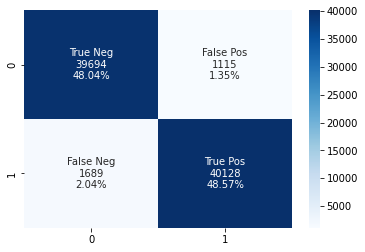

In [84]:
cf_matrix=metrics_train_dt.confusionMatrix().toArray()
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

<AxesSubplot:>

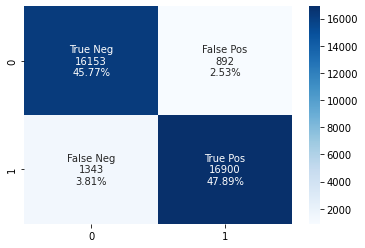

In [85]:
cf_matrix=metrics_dt.confusionMatrix().toArray()
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

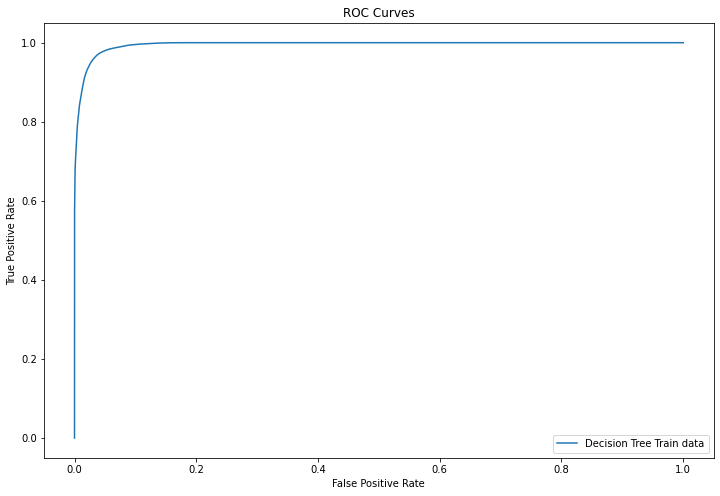

In [86]:
figure, ax = plt.subplots(figsize=(12,8))
plt.title("ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
for model in [cvModel_dt]:
    predictions = model.transform(train_data).select("customer_satisfactionIndex", "probability").withColumn('customer_satisfactionIndex', f.col('customer_satisfactionIndex'). \
        cast('double')).rdd.map(lambda row: (float(row['probability'][1]), float(row['customer_satisfactionIndex'])))
    points =CurveMetrics(predictions).get_curve('roc')
    x_val= [x[0] for x in points]
    y_val = [x[1] for x in points]
    ax.plot(x_val, y_val)
ax.legend(labels = ['Decision Tree Train data'])

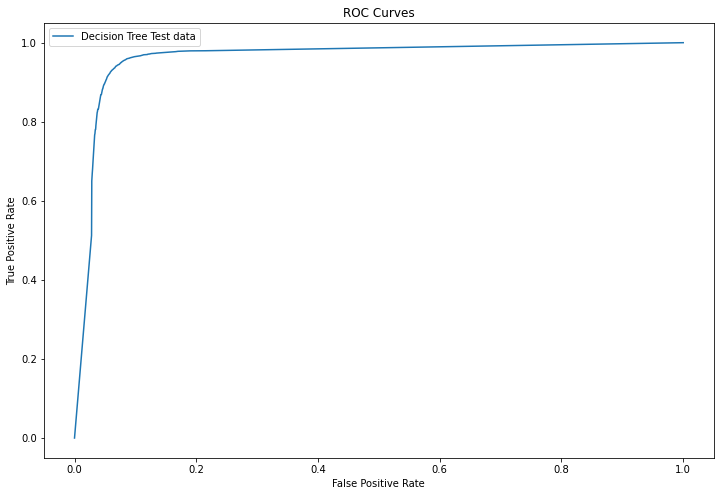

In [87]:
figure, ax = plt.subplots(figsize=(12,8))
plt.title("ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
for model in [cvModel_dt]:
    predictions = model.transform(test_data).select("customer_satisfactionIndex", "probability").withColumn('customer_satisfactionIndex', f.col('customer_satisfactionIndex'). \
        cast('double')).rdd.map(lambda row: (float(row['probability'][1]), float(row['customer_satisfactionIndex'])))
    points =CurveMetrics(predictions).get_curve('roc')
    x_val= [x[0] for x in points]
    y_val = [x[1] for x in points]
    ax.plot(x_val, y_val)
ax.legend(labels = ['Decision Tree Test data'])

In [88]:
dt_test = DecisionTreeClassifier(labelCol="customer_satisfactionIndex", featuresCol="features",maxDepth=20, maxBins=75 )
model_dt = dt_test.fit(train_data)

ff = model_dt.featureImportances
importancesList=[float(col) for col in  ff]
colList = df_resampled.columns
importances_dt=dict(zip(colList,importancesList))
print(importances_dt)

23/10/12 01:12:10 WARN DAGScheduler: Broadcasting large task binary with size 1086.8 KiB
23/10/12 01:12:10 WARN DAGScheduler: Broadcasting large task binary with size 1182.1 KiB
23/10/12 01:12:10 WARN DAGScheduler: Broadcasting large task binary with size 1266.5 KiB


{'GenderIndex': 0.006904000898343636, 'AgeIndex': 0.078209692738585, 'purpose_of_travelIndex': 0.016575846395862015, 'Type_Of_BookingIndex': 0.26915481702764676, 'Hotel wifi serviceIndex': 0.3351863738059071, 'Departure/Arrival  convenienceIndex': 0.03155182506416724, 'Ease of Online bookingIndex': 0.011702744530183915, 'Hotel locationIndex': 0.03893665831242077, 'Food and drinkIndex': 0.010640979321269083, 'Stay comfortIndex': 0.03241750073891028, 'Common Room entertainmentIndex': 0.11112786464579436, 'Checkin/Checkout serviceIndex': 0.02296178503472662, 'Other serviceIndex': 0.01939199088782385, 'CleanlinessIndex': 0.015237920598359482}


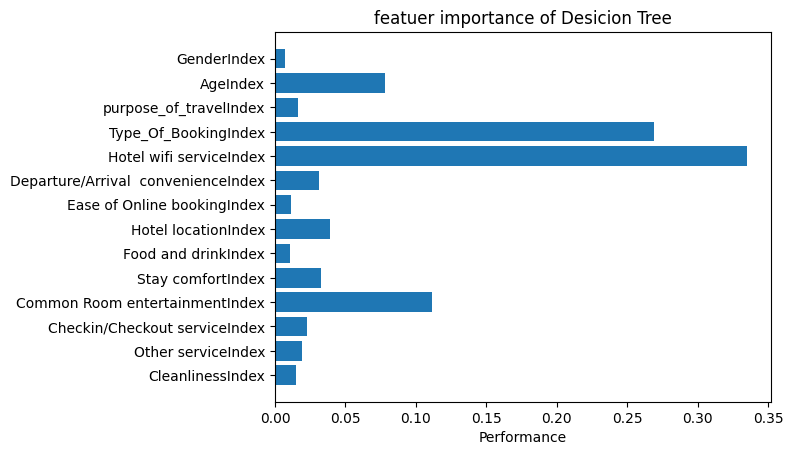

<Figure size 1000x700 with 0 Axes>

In [89]:
plt.rcdefaults()
fig, ax = plt.subplots()
fig = plt.figure(figsize =(10, 7))
ax.barh(range(len(importances_dt)), importances_dt.values(), align='center')
ax.set_yticks(range(len(importances_dt)), labels=list(importances_dt.keys()))
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('featuer importance of Desicion Tree')

plt.show()

In [90]:
# model_dt.toDebugString

# Random Forest

In [91]:
# Define your Random Forest classifier
rf_gv = RandomForestClassifier(labelCol="customer_satisfactionIndex", featuresCol="features")

# Create a pipeline with the Random Forest classifier
pipeline_rf_gv = Pipeline(stages=[rf_gv])

grid = ParamGridBuilder() \
    .addGrid(rf_gv.maxDepth, [15, 20]) \
    .addGrid(rf_gv.maxBins, [75, 150]) \
    .addGrid(rf_gv.numTrees, [10, 15]) \
    .addGrid(rf_gv.impurity, ['gini', 'entropy']) \
    .build()

evaluator = MulticlassClassificationEvaluator(
    labelCol="customer_satisfactionIndex",
    predictionCol="prediction",
    metricName="accuracy"
)

cvModel_rf = CrossValidator(
    estimator=pipeline_rf_gv,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=5
).fit(train_data)

train_predictions_rf = cvModel_rf.bestModel.transform(train_data) \
    .select("customer_satisfactionIndex", "prediction") \
    .withColumn('customer_satisfactionIndex', f.col('customer_satisfactionIndex').cast('double')) \
    .rdd

predictions_rf = cvModel_rf.bestModel.transform(test_data) \
    .select("customer_satisfactionIndex", "prediction") \
    .withColumn('customer_satisfactionIndex', f.col('customer_satisfactionIndex').cast('double')) \
    .rdd

# Calculate metrics
train_metrics_rf = MulticlassMetrics(train_predictions_rf)
metrics_rf = MulticlassMetrics(predictions_rf)

display("Confusion Matrix (Training Data):")
precision_acc(train_metrics_rf.confusionMatrix().toArray()).show()
print("Accuracy on Training Data (Random Forset): {:.4f}".format(train_metrics_rf.accuracy))

precision_acc(metrics_rf.confusionMatrix().toArray()).show()
display("Accuracy: {}".format(round(metrics_rf.accuracy,4)))
display("Best Parameters: {}".format(getBestPrams(cvModel_rf)))

23/10/12 01:12:16 WARN DAGScheduler: Broadcasting large task binary with size 1028.3 KiB
23/10/12 01:12:17 WARN DAGScheduler: Broadcasting large task binary with size 1554.3 KiB
23/10/12 01:12:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/10/12 01:12:19 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/10/12 01:12:20 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/10/12 01:12:22 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
23/10/12 01:12:24 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
23/10/12 01:12:27 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/10/12 01:12:33 WARN DAGScheduler: Broadcasting large task binary with size 1408.9 KiB
23/10/12 01:12:34 WARN DAGScheduler: Broadcasting large task binary with size 2004.1 KiB
23/10/12 01:12:35 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/10/12 01:12:37 WARN DAGScheduler: Broad

23/10/12 01:20:08 WARN DAGScheduler: Broadcasting large task binary with size 2011.4 KiB
23/10/12 01:20:09 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/10/12 01:20:11 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
23/10/12 01:20:13 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
23/10/12 01:20:16 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
23/10/12 01:20:19 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/10/12 01:20:22 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
23/10/12 01:20:26 WARN DAGScheduler: Broadcasting large task binary with size 1029.0 KiB
23/10/12 01:20:26 WARN DAGScheduler: Broadcasting large task binary with size 1547.0 KiB
23/10/12 01:20:27 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/10/12 01:20:29 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/10/12 01:20:30 WARN DAGScheduler: Broadcas

23/10/12 01:27:36 WARN DAGScheduler: Broadcasting large task binary with size 1399.9 KiB
23/10/12 01:27:37 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/10/12 01:27:39 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/10/12 01:27:41 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
23/10/12 01:27:43 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
23/10/12 01:27:46 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
23/10/12 01:27:48 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/10/12 01:27:52 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
23/10/12 01:27:57 WARN DAGScheduler: Broadcasting large task binary with size 1370.8 KiB
23/10/12 01:27:58 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/10/12 01:27:59 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/10/12 01:28:01 WARN DAGScheduler: Broadcastin

23/10/12 01:35:11 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
23/10/12 01:35:14 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
23/10/12 01:35:17 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/10/12 01:35:20 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
23/10/12 01:35:22 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
23/10/12 01:35:27 WARN DAGScheduler: Broadcasting large task binary with size 1397.8 KiB
23/10/12 01:35:28 WARN DAGScheduler: Broadcasting large task binary with size 1984.8 KiB
23/10/12 01:35:29 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/10/12 01:35:30 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
23/10/12 01:35:32 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
23/10/12 01:35:34 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
23/10/12 01:35:36 WARN DAGScheduler: Broadcastin

23/10/12 01:42:58 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
23/10/12 01:43:01 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
23/10/12 01:43:05 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB
23/10/12 01:43:09 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
23/10/12 01:43:13 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
23/10/12 01:43:17 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
23/10/12 01:43:23 WARN DAGScheduler: Broadcasting large task binary with size 1354.0 KiB
23/10/12 01:43:24 WARN DAGScheduler: Broadcasting large task binary with size 2029.0 KiB
23/10/12 01:43:26 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/10/12 01:43:28 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
23/10/12 01:43:29 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/10/12 01:43:32 WARN DAGScheduler: Broad

'Confusion Matrix (Training Data):'

23/10/12 01:46:46 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


+---+---------+------+----+
|   |precision|recall|  f1|
+---+---------+------+----+
|  0|     0.99|   1.0|0.99|
|  1|      1.0|  0.99|0.99|
+---+---------+------+----+

Accuracy on Training Data (Random Forset): 0.9913


23/10/12 01:46:51 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


+---+---------+------+----+
|   |precision|recall|  f1|
+---+---------+------+----+
|  0|     0.94|  0.96|0.95|
|  1|     0.97|  0.94|0.95|
+---+---------+------+----+



'Accuracy: 0.952'

"Best Parameters: {'maxDepth': 20, 'maxBins': 75, 'numTrees': 10, 'impurity': 'entropy'}"

In [100]:
df_conf_mat(train_metrics_rf.confusionMatrix().toArray()).show()
precision_acc(train_metrics_rf.confusionMatrix().toArray()).show()
print("Accuracy on Training Data (Random Forset): {:.4f}".format(train_metrics_rf.accuracy))


df_conf_mat(metrics_rf.confusionMatrix().toArray()).show()
precision_acc(metrics_rf.confusionMatrix().toArray()).show()
display("Accuracy on test data (Random Forset): {}".format(round(metrics_rf.accuracy,4)))
display("Best Parameters: {}".format(getBestPrams(cvModel_rf)))

+--------+-----------+-----------+
|        |Predicted_0|Predicted_1|
+--------+-----------+-----------+
|Actual_0|      40852|        190|
|Actual_1|        531|      41053|
+--------+-----------+-----------+

+---+---------+------+----+
|   |precision|recall|  f1|
+---+---------+------+----+
|  0|     0.99|   1.0|0.99|
|  1|      1.0|  0.99|0.99|
+---+---------+------+----+

Accuracy on Training Data (Random Forset): 0.9913
+--------+-----------+-----------+
|        |Predicted_0|Predicted_1|
+--------+-----------+-----------+
|Actual_0|      16411|        608|
|Actual_1|       1085|      17184|
+--------+-----------+-----------+

+---+---------+------+----+
|   |precision|recall|  f1|
+---+---------+------+----+
|  0|     0.94|  0.96|0.95|
|  1|     0.97|  0.94|0.95|
+---+---------+------+----+



'Accuracy on test data (Random Forset): 0.952'

"Best Parameters: {'maxDepth': 20, 'maxBins': 75, 'numTrees': 10, 'impurity': 'entropy'}"

<AxesSubplot:>

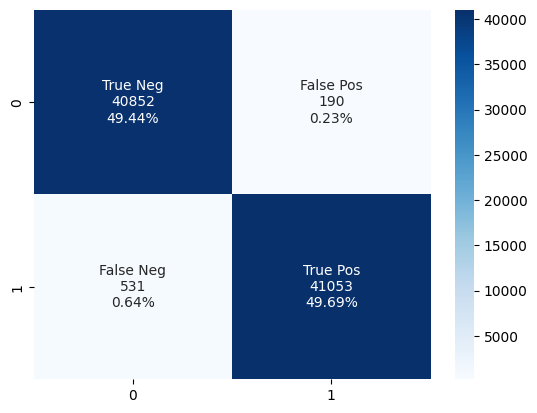

In [101]:
cf_matrix=train_metrics_rf.confusionMatrix().toArray()
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

<AxesSubplot:>

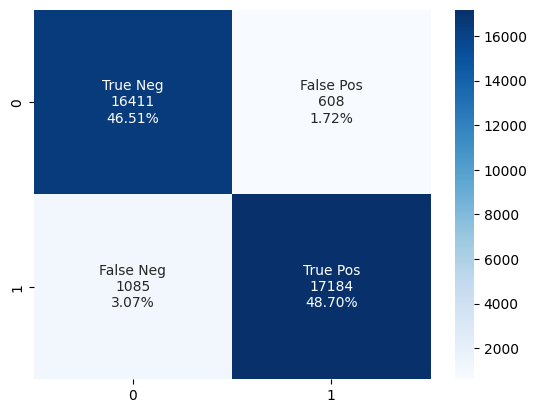

In [102]:
cf_matrix=metrics_rf.confusionMatrix().toArray()
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

23/10/12 01:50:04 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
23/10/12 01:50:06 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


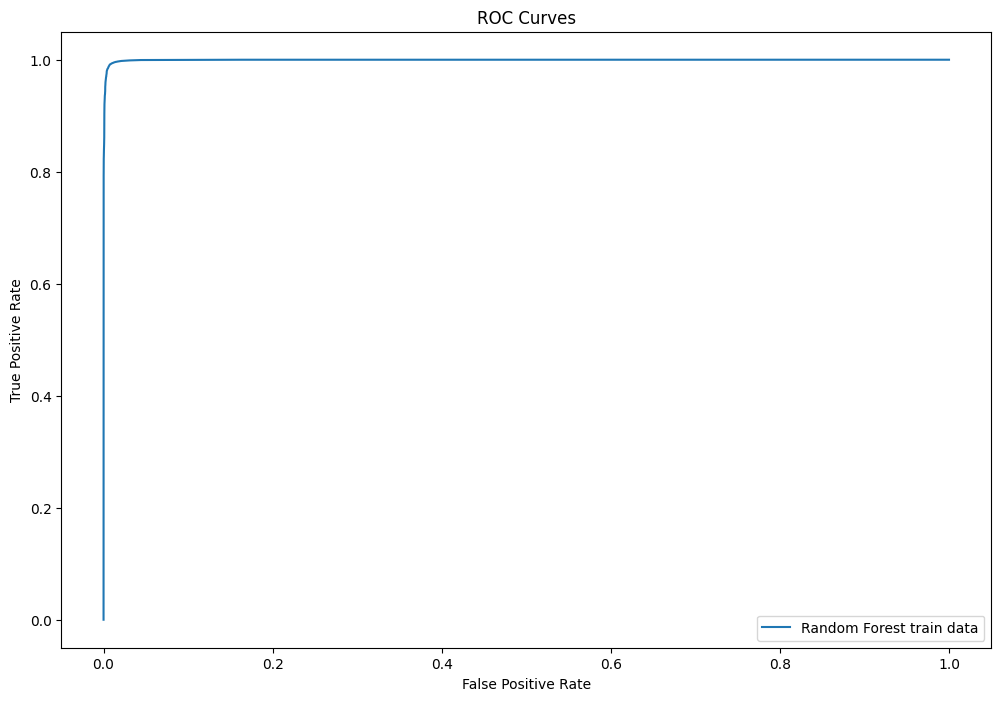

In [103]:
figure, ax = plt.subplots(figsize=(12,8))
plt.title("ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
for model in [cvModel_rf]:
    predictions = model.transform(train_data).select("customer_satisfactionIndex", "probability").withColumn('customer_satisfactionIndex', f.col('customer_satisfactionIndex'). \
        cast('double')).rdd.map(lambda row: (float(row['probability'][1]), float(row['customer_satisfactionIndex'])))
    points = CurveMetrics(predictions).get_curve('roc')
    x_val = [x[0] for x in points]
    y_val = [x[1] for x in points]
    ax.plot(x_val, y_val)
ax.legend(labels = ['Random Forest train data'])

23/10/12 01:50:21 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
23/10/12 01:50:22 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


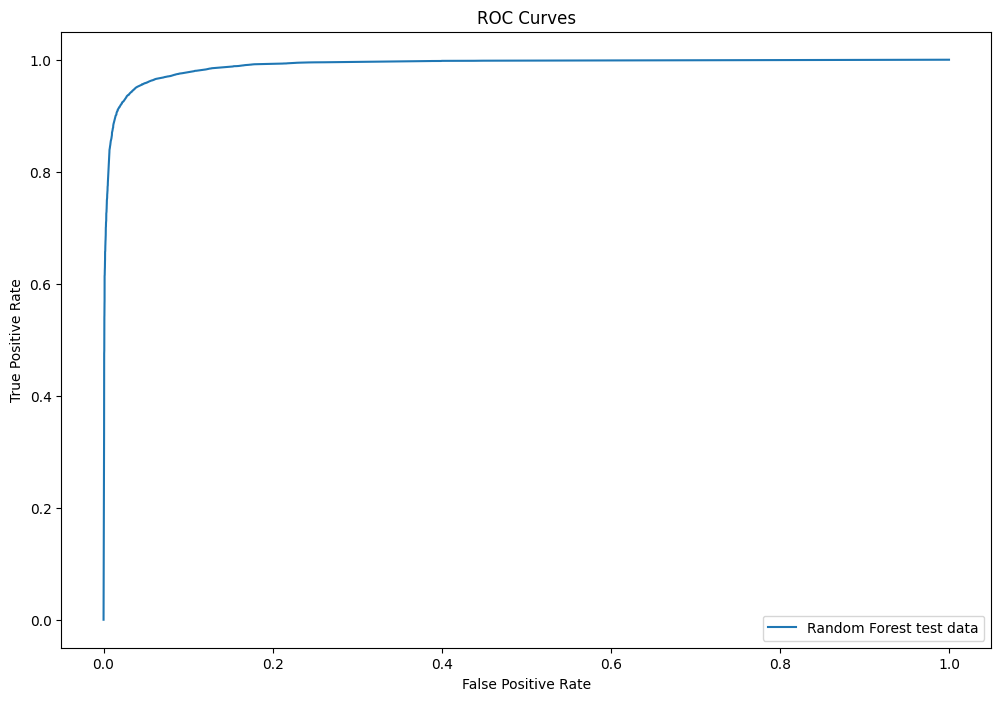

In [104]:
figure, ax = plt.subplots(figsize=(12,8))
plt.title("ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
for model in [cvModel_rf]:
    predictions = model.transform(test_data).select("customer_satisfactionIndex", "probability").withColumn('customer_satisfactionIndex', f.col('customer_satisfactionIndex'). \
        cast('double')).rdd.map(lambda row: (float(row['probability'][1]), float(row['customer_satisfactionIndex'])))
    points = CurveMetrics(predictions).get_curve('roc')
    x_val = [x[0] for x in points]
    y_val = [x[1] for x in points]
    ax.plot(x_val, y_val)
ax.legend(labels = ['Random Forest test data'])

In [105]:
rf = RandomForestClassifier(labelCol="customer_satisfactionIndex", featuresCol="features",maxDepth=20, maxBins=75 )
model_rf = rf.fit(train_data) 
rf_i = model_rf.featureImportances
importancesList=[float(col) for col in  rf_i]
colList = df_resampled.columns
importances_rf=dict(zip(colList,importancesList))
print(importances_rf)

23/10/12 01:51:00 WARN DAGScheduler: Broadcasting large task binary with size 1162.7 KiB
23/10/12 01:51:01 WARN DAGScheduler: Broadcasting large task binary with size 1897.3 KiB
23/10/12 01:51:03 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/10/12 01:51:06 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
23/10/12 01:51:09 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/10/12 01:51:13 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
23/10/12 01:51:18 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
23/10/12 01:51:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
23/10/12 01:51:29 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB
23/10/12 01:51:36 WARN DAGScheduler: Broadcasting large task binary with size 17.4 MiB
23/10/12 01:51:42 WARN DAGScheduler: Broadcasting large task binary with size 19.2 MiB
23/10/12 01:51:49 WARN DAGScheduler: Broadc

{'GenderIndex': 0.005985509283875134, 'AgeIndex': 0.10667002940728901, 'purpose_of_travelIndex': 0.015255914705272428, 'Type_Of_BookingIndex': 0.17899262000245314, 'Hotel wifi serviceIndex': 0.24362962524937296, 'Departure/Arrival  convenienceIndex': 0.056545646144715335, 'Ease of Online bookingIndex': 0.054203501370947, 'Hotel locationIndex': 0.059251414402951105, 'Food and drinkIndex': 0.01648148771938549, 'Stay comfortIndex': 0.08248503182648506, 'Common Room entertainmentIndex': 0.07832423521056661, 'Checkin/Checkout serviceIndex': 0.0307159022999889, 'Other serviceIndex': 0.0376638652241476, 'CleanlinessIndex': 0.03379521715255014}


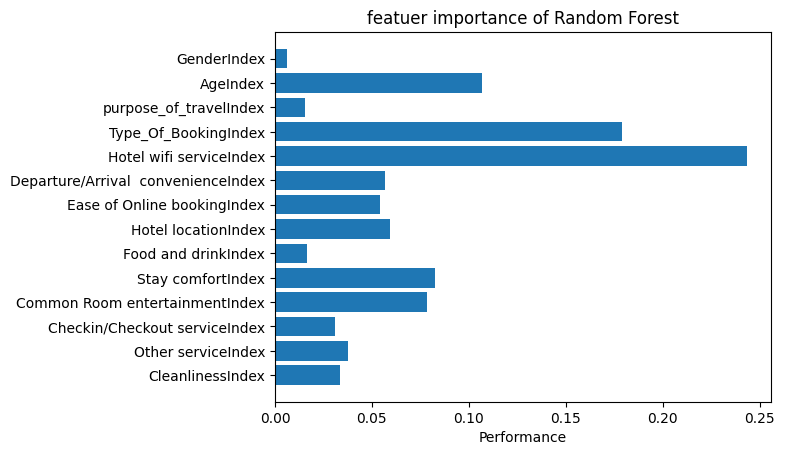

<Figure size 1000x700 with 0 Axes>

In [106]:
plt.rcdefaults()
fig, ax = plt.subplots()
fig = plt.figure(figsize =(10, 7))
ax.barh(range(len(importances_rf)), importances_rf.values(), align='center')
ax.set_yticks(range(len(importances_rf)), labels=list(importances_rf.keys()))
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('featuer importance of Random Forest')

plt.show()

In [ ]:
#model_rf.toDebugString

## Addition Phase1

In [66]:
# Split the training and testing set.
vecAssembler = VectorAssembler(inputCols=df_resampled.drop('customer_satisfactionIndex').columns, outputCol='features')
data = vecAssembler.transform(df_resampled)
(train_data2, test_data2) = data.randomSplit([0.8, 0.2])
print(train_data2.count())
print(test_data2.count())

23/10/12 04:43:09 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


94200


23714


In [67]:
from pyspark.sql.types import StructType, StructField, StringType, FloatType

# Define your Random Forest classifier
rf_gv = RandomForestClassifier(labelCol="customer_satisfactionIndex", featuresCol="features")

# Create a pipeline with the Random Forest classifier
pipeline_rf_gv = Pipeline(stages=[rf_gv])

grid = ParamGridBuilder() \
    .addGrid(rf_gv.maxDepth, [15, 20]) \
    .addGrid(rf_gv.maxBins, [75, 150]) \
    .addGrid(rf_gv.numTrees, [10, 15]) \
    .addGrid(rf_gv.impurity, ['gini', 'entropy']) \
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol="customer_satisfactionIndex", 
                                              predictionCol="prediction", metricName="accuracy")

cvModel_rf4 =CrossValidator(estimator =pipeline_rf_gv, estimatorParamMaps= grid, 
                            evaluator= evaluator, numFolds= 5).fit(train_data2)

predictions_rf4 = cvModel_rf4.bestModel.transform(test_data2).select("customer_satisfactionIndex", "prediction").withColumn('customer_satisfactionIndex', f.col('customer_satisfactionIndex').cast('double')).rdd
metrics_rf4 = MulticlassMetrics(predictions_rf4)

precision_acc(metrics_rf4.confusionMatrix().toArray()).show()
display("Accuracy: {}".format(round(metrics_rf4.accuracy,2)))
display("Best Parameters: {}".format(getBestPrams(cvModel_rf4)))

23/10/12 04:43:32 WARN DAGScheduler: Broadcasting large task binary with size 1025.0 KiB
23/10/12 04:43:33 WARN DAGScheduler: Broadcasting large task binary with size 1561.7 KiB
23/10/12 04:43:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/10/12 04:43:36 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/10/12 04:43:37 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/10/12 04:43:39 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
23/10/12 04:43:42 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
23/10/12 04:43:44 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/10/12 04:43:53 WARN DAGScheduler: Broadcasting large task binary with size 1465.9 KiB
23/10/12 04:43:54 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/10/12 04:43:55 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/10/12 04:43:56 WARN DAGScheduler: Broadcas

23/10/12 04:47:25 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
23/10/12 04:47:29 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
23/10/12 04:47:33 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
23/10/12 04:47:38 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
23/10/12 04:47:42 WARN DAGScheduler: Broadcasting large task binary with size 15.8 MiB
23/10/12 04:47:46 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
23/10/12 04:47:52 WARN DAGScheduler: Broadcasting large task binary with size 1380.6 KiB
23/10/12 04:47:54 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/10/12 04:47:55 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/10/12 04:47:57 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/10/12 04:48:00 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
23/10/12 04:48:03 WARN DAGScheduler: Broadcas

23/10/12 04:52:04 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/10/12 04:52:06 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/10/12 04:52:08 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
23/10/12 04:52:10 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
23/10/12 04:52:13 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
23/10/12 04:52:16 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
23/10/12 04:52:19 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/10/12 04:52:23 WARN DAGScheduler: Broadcasting large task binary with size 1035.8 KiB
23/10/12 04:52:24 WARN DAGScheduler: Broadcasting large task binary with size 1573.6 KiB
23/10/12 04:52:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/10/12 04:52:26 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/10/12 04:52:28 WARN DAGScheduler: Broadcastin

23/10/12 04:56:15 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
23/10/12 04:56:17 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/10/12 04:56:19 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
23/10/12 04:56:22 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/10/12 04:56:25 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
23/10/12 04:56:28 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
23/10/12 04:56:30 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
23/10/12 04:56:34 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
23/10/12 04:56:40 WARN DAGScheduler: Broadcasting large task binary with size 1441.6 KiB
23/10/12 04:56:41 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/10/12 04:56:43 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/10/12 04:56:45 WARN DAGScheduler: Broadcasting 

23/10/12 05:00:42 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/10/12 05:00:44 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/10/12 05:00:47 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/10/12 05:00:50 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/10/12 05:00:53 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
23/10/12 05:00:58 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
23/10/12 05:01:03 WARN DAGScheduler: Broadcasting large task binary with size 1377.8 KiB
23/10/12 05:01:04 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/10/12 05:01:06 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/10/12 05:01:08 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/10/12 05:01:10 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
23/10/12 05:01:13 WARN DAGScheduler: Broadcasting l

23/10/12 05:05:06 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/10/12 05:05:09 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/10/12 05:05:12 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
23/10/12 05:05:16 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
23/10/12 05:05:20 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
23/10/12 05:05:25 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
23/10/12 05:05:30 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
23/10/12 05:05:34 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB
23/10/12 05:05:39 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
23/10/12 05:05:46 WARN DAGScheduler: Broadcasting large task binary with size 1377.9 KiB
23/10/12 05:05:47 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/10/12 05:05:49 WARN DAGScheduler: Broadcas

23/10/12 05:09:21 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
23/10/12 05:09:24 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
23/10/12 05:09:27 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
23/10/12 05:09:32 WARN DAGScheduler: Broadcasting large task binary with size 1457.3 KiB
23/10/12 05:09:33 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/10/12 05:09:34 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/10/12 05:09:36 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/12 05:09:37 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/10/12 05:09:39 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
23/10/12 05:09:41 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
23/10/12 05:09:44 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
23/10/12 05:09:46 WARN DAGScheduler: Broadcasting

23/10/12 05:14:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/10/12 05:14:13 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/10/12 05:14:14 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/10/12 05:14:16 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
23/10/12 05:14:19 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
23/10/12 05:14:21 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/10/12 05:14:28 WARN DAGScheduler: Broadcasting large task binary with size 1453.8 KiB
23/10/12 05:14:30 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/10/12 05:14:31 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/10/12 05:14:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/12 05:14:35 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/10/12 05:14:37 WARN DAGScheduler: Broadcasting l

23/10/12 05:18:24 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
23/10/12 05:18:29 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB
23/10/12 05:18:34 WARN DAGScheduler: Broadcasting large task binary with size 16.0 MiB
23/10/12 05:18:39 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
23/10/12 05:18:45 WARN DAGScheduler: Broadcasting large task binary with size 1387.9 KiB
23/10/12 05:18:46 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/10/12 05:18:48 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/10/12 05:18:50 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/10/12 05:18:52 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
23/10/12 05:18:55 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/10/12 05:18:58 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
23/10/12 05:19:01 WARN DAGScheduler: Broadcasti

NameError: name 'StructType' is not defined

In [69]:
from pyspark.sql.types import StructType, StructField, StringType, FloatType

metrics_rf = MulticlassMetrics(predictions_rf4)


precision_acc(metrics_rf.confusionMatrix().toArray()).show()
display("Accuracy: {}".format(round(metrics_rf.accuracy,2)))
display("Best Parameters: {}".format(getBestPrams(cvModel_rf4)))

23/10/12 05:27:26 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB
23/10/12 05:27:28 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


+---+---------+------+----+
|   |precision|recall|  f1|
+---+---------+------+----+
|  0|     0.93|  0.97|0.95|
|  1|     0.97|  0.93|0.95|
+---+---------+------+----+



'Accuracy: 0.95'

"Best Parameters: {'maxDepth': 20, 'maxBins': 75, 'numTrees': 15, 'impurity': 'entropy'}"

<AxesSubplot:>

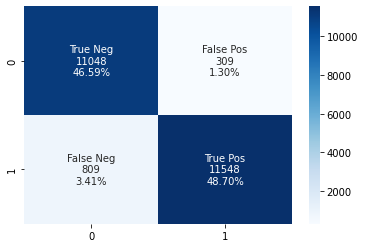

23/10/12 05:33:27 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
23/10/12 05:33:30 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/10/12 05:33:33 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
23/10/12 05:33:36 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
23/10/12 05:33:40 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
23/10/12 05:33:47 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
23/10/12 05:34:16 WARN DAGScheduler: Broadcasting large task binary with size 1411.8 KiB


In [77]:
cf_matrix=metrics_rf.confusionMatrix().toArray()
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

23/10/12 05:29:34 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB
23/10/12 05:29:37 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


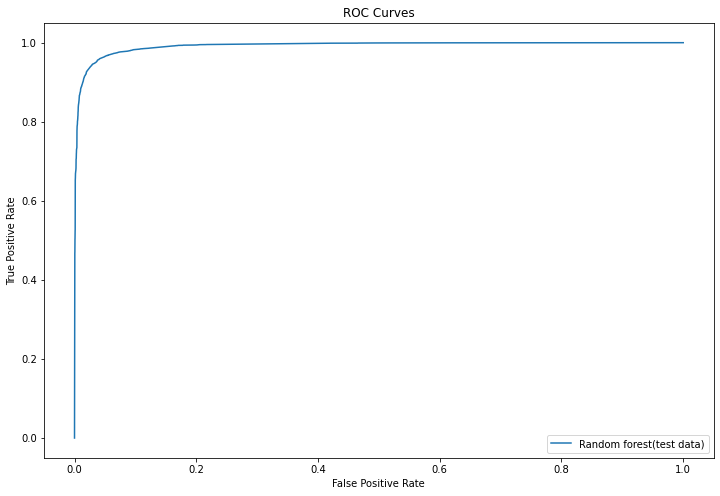

In [73]:
figure, ax = plt.subplots(figsize=(12,8))
plt.title("ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
for model in [cvModel_rf4]:
    predictions = model.transform(test_data2).select("customer_satisfactionIndex", "probability").withColumn('customer_satisfactionIndex', f.col('customer_satisfactionIndex'). \
        cast('double')).rdd.map(lambda row: (float(row['probability'][1]), float(row['customer_satisfactionIndex'])))
    points =CurveMetrics(predictions).get_curve('roc')
    x_val= [x[0] for x in points]
    y_val = [x[1] for x in points]
    ax.plot(x_val, y_val)
ax.legend(labels = ['Random forest(test data)'])